# Part-1

# Imports

In [1]:
import re
from tqdm import tqdm
from textblob import TextBlob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import nltk
from nltk.corpus import stopwords

# Handling the Dataset

In [2]:
data=pd.read_csv('dataset.csv')

In [3]:
data=data.iloc[0:12290,:]

In [4]:
data.head()

,Data,Date,Time,tweetcaption
0,tuesdayvibes,7/14/2020,7:00:21,Love it here vacation vibes amazing beautiful ...
1,realmeC11,7/14/2020,7:00:21,Best Camera Smartphone under 20k Please vote a...
2,KPSharmaOli,7/14/2020,7:00:21,shree Why should we have a problem with the pe...
3,RheaChakraborty,7/14/2020,7:00:21,Rhea Chakraborty s Heartbreaking Post On Susha...
4,Stop_Transfer_Sunita_Yadav,7/14/2020,7:00:21,We stand for Sunita Yadav Stop the Transfer Wh...


# Handling the functions

In [5]:
def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

def getSentimentTextBlob(polarity):
    if polarity < 0:
        return "Negative"
    else:
        return "Positive"

In [6]:
#nltk.download('stopwords')

In [7]:
def text_processing(s):
    s=s.lower()
    s = re.sub(r'[^\w\s]', '', s)
    s=re.sub('[0-9]+','',s)
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')])
    return s

In [8]:
data['tweet_processed']=data['tweetcaption'].apply(text_processing)

In [9]:
data['Polarity']=data['tweet_processed'].apply(getPolarity)
data['Sentiment']=data['Polarity'].apply(getSentimentTextBlob)

In [10]:
def sentimentscores(sentiment):
    if sentiment=="Positive":
        return 1
    else:
        return 0

In [11]:
data['Sentiment_score']=data['Sentiment'].apply(sentimentscores)

In [12]:
pos=0
n=0
neg=0
avg_neg_score=[]
avg_pos_score=[]
for i in range(data.shape[0]):
    n=n+1
    if(data.Sentiment_score[i]==0):
        neg=neg+1
    else:
        pos=pos+1
    avg_pos_score.append(pos/n)
    avg_neg_score.append(neg/n)

In [13]:
data['avg_pos_score']=avg_pos_score
data['avg_neg_score']=avg_neg_score

In [14]:
data.head()

,Data,Date,Time,tweetcaption,tweet_processed,Polarity,Sentiment,Sentiment_score,avg_pos_score,avg_neg_score
0,tuesdayvibes,7/14/2020,7:00:21,Love it here vacation vibes amazing beautiful ...,love vacation vibes amazing beautiful cabo mex...,0.239583,Positive,1,1.000000,0.000000
1,realmeC11,7/14/2020,7:00:21,Best Camera Smartphone under 20k Please vote a...,best camera smartphone k please vote help reac...,0.134387,Positive,1,1.000000,0.000000
2,KPSharmaOli,7/14/2020,7:00:21,shree Why should we have a problem with the pe...,shree problem people problem stupid communist ...,-0.037500,Negative,0,0.666667,0.333333
3,RheaChakraborty,7/14/2020,7:00:21,Rhea Chakraborty s Heartbreaking Post On Susha...,rhea chakraborty heartbreaking post sushant si...,0.100000,Positive,1,0.750000,0.250000
4,Stop_Transfer_Sunita_Yadav,7/14/2020,7:00:21,We stand for Sunita Yadav Stop the Transfer Wh...,stand sunita yadav stop transfer women empower...,0.213228,Positive,1,0.800000,0.200000


In [25]:
from sklearn.model_selection import train_test_split

X = data.tweet_processed.values
y = data.Sentiment_score.values

X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.1, random_state=20)

In [26]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [27]:
#pip install transformers

Tokenization

In [28]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def preprocessing_for_bert(data):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    for tweet in data:
        encoded_sent = tokenizer.encode_plus(text=tweet,add_special_tokens=True,max_length=MAX_LEN,truncation=True,
            pad_to_max_length=True,return_attention_mask=True)
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [29]:
MAX_LEN = 100

# sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())

# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

G:\anaconda\lib\site-packages\transformers\tokenization_utils_base.py:2221: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Create PyTorch DataLoader

In [30]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Training Our Model

Create BertClassifier

In [31]:
import torch.nn as nn
from transformers import BertModel

# Create the BertClassifier class
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(nn.Linear(D_in, H),nn.ReLU(),nn.Linear(H, D_out))

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Optimizer & Learning Rate Scheduler

In [32]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    bert_classifier = BertClassifier(freeze_bert=False)

    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),lr=5e-5,eps=1e-8)

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

Training Loop

In [33]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    #Set seed for reproducibility
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        #Evaluation
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance on our validation set
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Now, let's start training our BertClassifier!

In [34]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.426869   |     -      |     -     |  493.36  
   1    |   40    |   0.406791   |     -      |     -     |  471.65  
   1    |   60    |   0.339600   |     -      |     -     |  468.80  
   1    |   80    |   0.312584   |     -      |     -     |  477.53  
   1    |   100   |   0.304844   |     -      |     -     |  475.08  
   1    |   120   |   0.298202   |     -      |     -     |  474.07  
   1    |   140   |   0.240278   |     -      |     -     |  438.69  
   1    |   160   |   0.214384   |     -      |     -     |  299.96  
   1    |   180   |   0.186537   |     -      |     -     |  283.35  
   1    |   200   |   0.185926   |     -      |     -     |  282.85  
   1    |   220   |   0.187108   |     -      |     -     |  276.35  
   1    |   240   |   0.153363   |     -      |     -     |  278.33  


Evaluation on Validation Set

In [35]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    # Put the model into the evaluation mode
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [36]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

In [37]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

AUC: 0.9840
Accuracy: 98.21%


In [38]:
data.head()

,Data,Date,Time,tweetcaption,tweet_processed,Polarity,Sentiment,Sentiment_score,avg_pos_score,avg_neg_score
0,tuesdayvibes,7/14/2020,7:00:21,Love it here vacation vibes amazing beautiful ...,love vacation vibes amazing beautiful cabo mex...,0.239583,Positive,1,1.000000,0.000000
1,realmeC11,7/14/2020,7:00:21,Best Camera Smartphone under 20k Please vote a...,best camera smartphone k please vote help reac...,0.134387,Positive,1,1.000000,0.000000
2,KPSharmaOli,7/14/2020,7:00:21,shree Why should we have a problem with the pe...,shree problem people problem stupid communist ...,-0.037500,Negative,0,0.666667,0.333333
3,RheaChakraborty,7/14/2020,7:00:21,Rhea Chakraborty s Heartbreaking Post On Susha...,rhea chakraborty heartbreaking post sushant si...,0.100000,Positive,1,0.750000,0.250000
4,Stop_Transfer_Sunita_Yadav,7/14/2020,7:00:21,We stand for Sunita Yadav Stop the Transfer Wh...,stand sunita yadav stop transfer women empower...,0.213228,Positive,1,0.800000,0.200000


# Part2

# Plots

In [15]:
#day wise analysis

In [66]:
df=data.loc[data['Date']=='7/19/2020']

In [67]:
df.shape

(685, 10)

G:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sentiment Distribution')

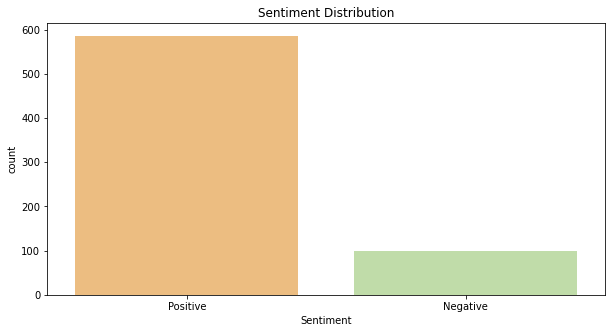

In [68]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.countplot(df.Sentiment,palette='Spectral')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.title('Sentiment Distribution')

In [83]:
x=list(i for i in range(df.shape[0]))
y=df.avg_pos_score

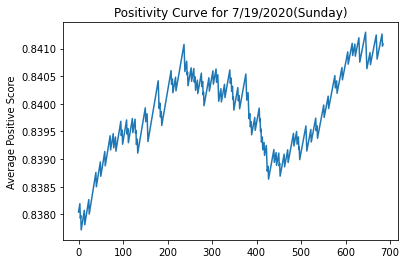

In [84]:
plt.plot(x,y)
plt.ylabel('Average Positive Score')
plt.title('Positivity Curve for 7/19/2020(Sunday)')
plt.show()

In [85]:
x=list(i for i in range(df.shape[0]))
y=df.avg_neg_score

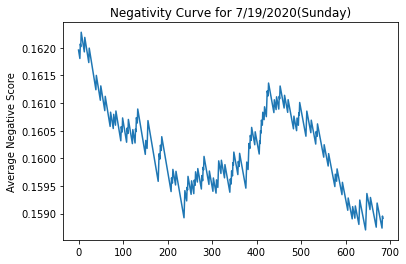

In [87]:
plt.plot(x,y)
plt.ylabel('Average Negative Score')
plt.title('Negativity Curve for 7/19/2020(Sunday)')
plt.show()

In [88]:
df1=data.loc[data['Date']=='7/20/2020']

In [89]:
df1.shape

(770, 10)

G:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sentiment Distribution')

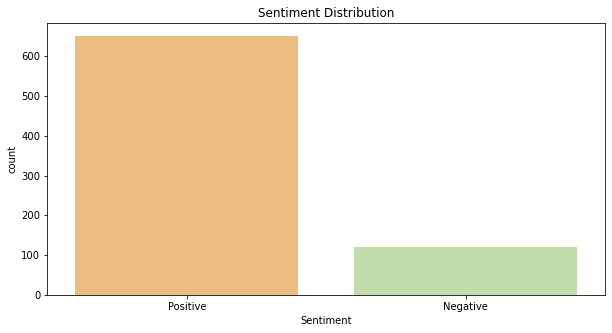

In [90]:
plt.figure(figsize=(10,5))
sns.countplot(df1.Sentiment,palette='Spectral')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.title('Sentiment Distribution')

In [91]:
x=list(i for i in range(df1.shape[0]))
y=df1.avg_pos_score

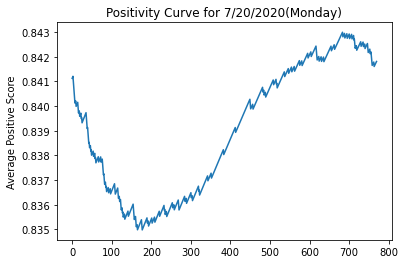

In [93]:
plt.plot(x,y)
plt.ylabel('Average Positive Score')
plt.title('Positivity Curve for 7/20/2020(Monday)')
plt.show()

In [94]:
x=list(i for i in range(df1.shape[0]))
y=df1.avg_neg_score

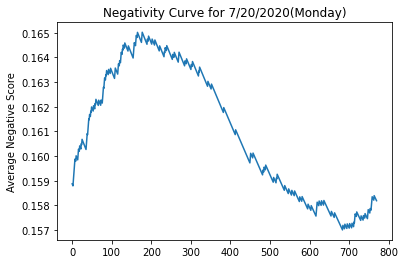

In [95]:
plt.plot(x,y)
plt.ylabel('Average Negative Score')
plt.title('Negativity Curve for 7/20/2020(Monday)')
plt.show()

In [96]:
#one week analysis

In [97]:
df2=data.loc[0:5444,:]

In [98]:
df2.shape

(5445, 10)

G:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sentiment Distribution')

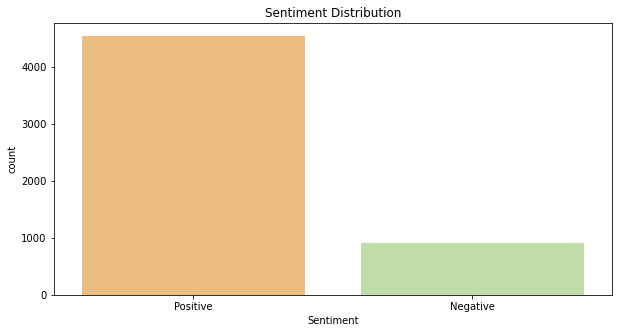

In [99]:
plt.figure(figsize=(10,5))
sns.countplot(df2.Sentiment,palette='Spectral')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.title('Sentiment Distribution')

In [101]:
x=list(i for i in range(df2.shape[0]))
y=df2.avg_pos_score

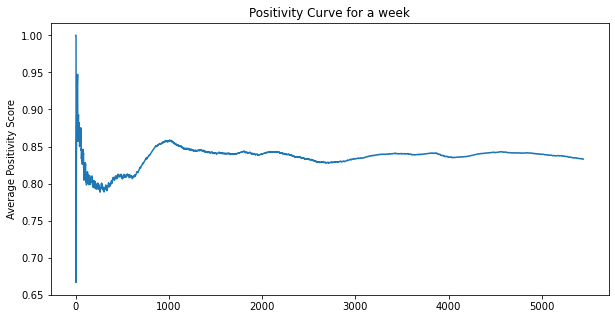

In [102]:
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.ylabel('Average Positivity Score')
plt.title('Positivity Curve for a week')
plt.show()

In [103]:
x=list(i for i in range(df2.shape[0]))
y=df2.avg_neg_score

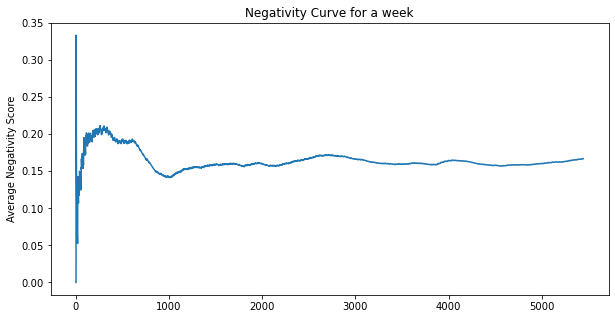

In [104]:
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.ylabel('Average Negativity Score')
plt.title('Negativity Curve for a week')
plt.show()

In [105]:
#considering all rows of dataframe

In [106]:
data.shape

(12290, 10)

G:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sentiment Distribution')

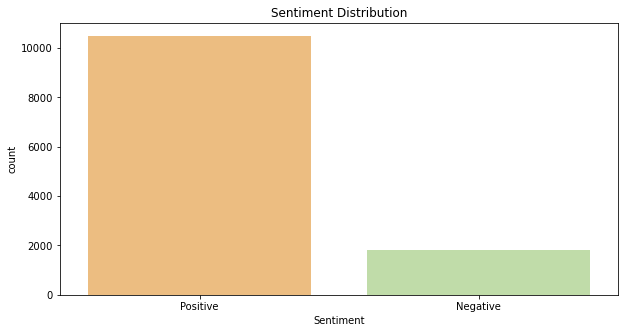

In [107]:
plt.figure(figsize=(10,5))
sns.countplot(data.Sentiment,palette='Spectral')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.title('Sentiment Distribution')

In [108]:
x=list(i for i in range(data.shape[0]))
y=data.avg_pos_score

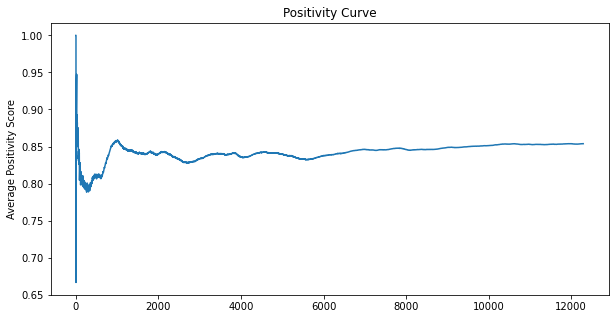

In [109]:
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.ylabel('Average Positivity Score')
plt.title('Positivity Curve')
plt.show()

In [110]:
x=list(i for i in range(data.shape[0]))
y=data.avg_neg_score

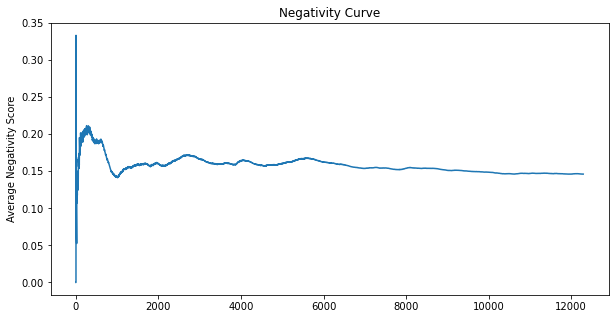

In [111]:
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.ylabel('Average Negativity Score')
plt.title('Negativity Curve')
plt.show()

# Conclusion

We can see that Positive tweets are nearly five times the number of negative tweets in one day, one week and the whole dataframe analysis of count of tweets. From the negativity and positivity curve of one week and whole datframe we can conclude that the average positive score and average negative score became constant after some time. These curves show us the increase or decrease in average positive and average negative score with the passage of time.